# 細胞

## [C1] 相分離

- L*LのセルにN個の粒子を置く．
- 各粒子をランダムに上下左右に動かす．ただし，上下左右の粒子の数×E のエネルギーを持つとして，局所詳細つり合いを守るような遷移率で動かす．周期境界条件である．
- 計算にはGillespieアルゴリズム（たとえば，金子，澤井，高木，古澤「細胞の理論生物学」（東大出版，2020年）が詳しい）を使用．
- 粒子数 N を変えると，振る舞いが変わる．Nが少ないときや多いときはドロップレット状のパターンが生じ，中間ぐらい（N = L*L/2）では共連結型（スプノーダル分解）となる．
13.5節参照．

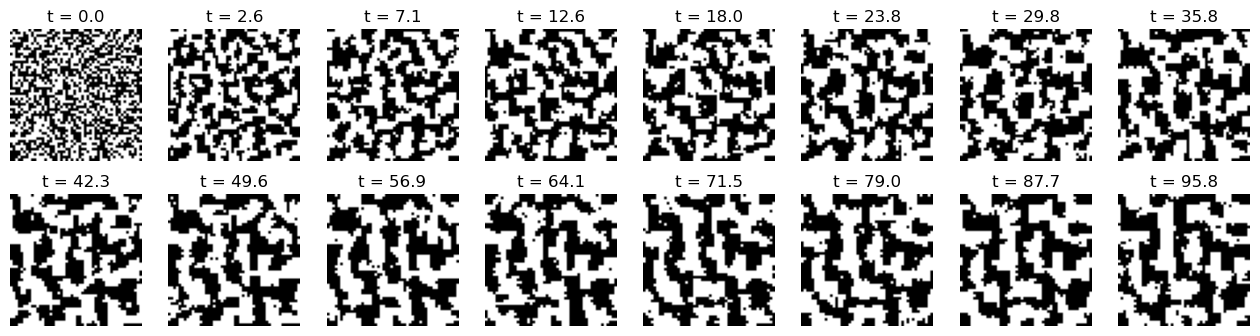

In [183]:
import numpy as np # 計算用ライブラリ
import matplotlib.pyplot as plt  # プロット用ライブラリ
    
L = 50 # 全体の大きさ（1辺の長さ）
N = 1250  # 粒子密度（0 - 1）
stepN = 80000 # 計算ステップ数

E = -2  # 粒子同士の相互作用 (kbT)．周囲に1つも粒子がいないときに比べて，3つの粒子と接すると 3E だけ安定．
w0 = np.exp(-0.5*E*np.array([0, 1, 2, 3, -3, -2, -1])) # 局所詳細つり合い関係を満たすために0.5倍する．

mx = [1, 0, -1, 0]
my = [0, 1, 0, -1]


# 初期配置
def init():
    k = np.random.choice(L*L, N, replace = False) # 重複なしに， L * Lのマス目の中からN 個を選ぶ．
    x = k // L
    y = k % L

    s = np.full((L, L), -1, dtype = np.int) # 状態．粒子がいない場所は-1．いる場所は粒子の番号．
    for i in range(N):
        s[x[i], y[i]] = i
     
    return x, y, s

# (px, py)の周りにある粒子数（0 - 4）を数える
def count(px, py, s):
    c = 0
    for m in range(4):
        if s[(px + mx[m])%L, (py + my[m])%L]>=0:
            c += 1
    return c

# 反応のリストを作る
def wlist(x, y, s):
    w = np.full((N, 4), 1) # 遷移率
    for i in range(N):
        w = updatewlist(i, x, y, s, w)
    return w

# 特定の粒子に関する遷移率をアップデート
def updatewlist(i, x, y, s, w):
    for m in range(4):
        nextx = (x[i] + mx[m])%L
        nexty = (y[i] + my[m])%L

        if s[nextx, nexty] >=0:
            w[i, m] = 0
        else:
            d = count(nextx, nexty, s) - count(x[i], y[i], s) # 遷移によって，隣り合う粒子の数が何個増えるか．
            w[i, m] = w0[d]

    return w

    
# メインルーチン

t = 0 # 時間 （単位は適当）

x, y, s = init() # 粒子配置の初期化

w = wlist(x, y, s) # 反応のリストを作る． w[n, m]は，n番目の粒子の m 番目の動き（右，上，左，下のどれ？）に対応する遷移率．

fig, ax = plt.subplots(ncols=8, nrows = 2, figsize=(16, 4), dpi = 100)

for i in range(stepN):    
    wsum = np.sum(w)
    wcum = np.cumsum(w / wsum) # 規格化したw の累積和 ．wsumは1次元配列（4N個の要素）．   

    # （ソート済みの）の）リスト wsum の中から，最初に r を超えるインデックスを探す．ただし， wsum は 4N個の1次元リストになっているので，粒子番号と動きの番号に変換する．
    r = np.random.rand()  
    k = np.argmax(wcum>r)
    p = k // 4 # 動かす粒子の番号
    m = k % 4 # 動かし方

    s[x[p], y[p]] = -1
    
    x0 = x[p]
    y0 = y[p]
    
    x[p] = (x[p] + mx[m])%L
    y[p] = (y[p] + my[m])%L
    s[x[p], y[p]] = p

    # 粒子の周辺にいる粒子に関係する遷移率をアップデート．2重カウントしているところもある．
    w = updatewlist(p, x, y, s, w)
    for mm in range(4):
        q = s[(x0+mx[mm])%L, (y0+my[mm])%L]
        if q>=0:
            w = updatewlist(q, x, y, s, w)  
            
    for mm in range(4):
        q = s[(x[p]+mx[mm])%L, (y[p]+my[mm])%L]
        if q>=0:
            w = updatewlist(q, x, y, s, w)  

    tau = -np.log(np.random.rand())/wsum # 反応にかかる時間
    t += tau # 時間を更新
    
    # 定期的にプロット
    if i % (stepN // 16) == 0:
        pl = i // (stepN // 16)
        a = ax[pl // 8, pl%8] 
        a.set_title('t = {:.1f}'.format(t))       
        a.imshow(s>=0, cmap='gray')
        a.axis('off')
   
plt.show()

# 集団運動

## [S1] ビチェックモデル

14.4節参照．

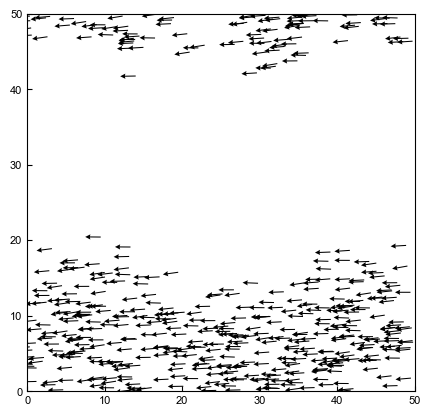

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin, arctan2, random, zeros, pi

v, dt, r, noise = 1, 1, 7, 0.2

N = 500 # 粒子の数
L = 50 # 領域の大きさ

# 初期値
x = random.rand(N)*L
y = random.rand(N)*L
theta = random.rand(N)*2*pi

# 繰り返し
stepN = 100
for i in range(stepN):    
    c = zeros(N)
    s = zeros(N)
    for k in range(N):       
        dx = x[k] - x
        dy = y[k] - y        
        
        dx = (dx + L/2)%L - L/2
        dy = (dy + L/2)%L - L/2
            
        f = dx*dx + dy*dy < r*r
        c[k] = sum(f * cos(theta))
        s[k] = sum(f * sin(theta))

    theta = arctan2(s, c) + (random.rand(N)-0.5)*noise
    
    x = (x + dt*v*cos(theta)) % L
    y = (y + dt*v*sin(theta)) % L
    
plt.figure(figsize=(5,5), dpi = 100)
plt.xlim(0, L)
plt.ylim(0, L)

plt.quiver(x, y, cos(theta), sin(theta), scale = 25, headwidth = 5) # プロット

plt.show()